In [1]:
from dolfinx import fem, mesh, plot, io, geometry
from dolfinx.fem.petsc import LinearProblem
from petsc4py.PETSc import ScalarType
from mpi4py import MPI
import numpy as np
from ufl import ds, dx, grad, inner
import ufl
import matplotlib as mpl
import pyvista
from typing import List, Tuple
from src.visualization import timeDependentVariableToGif, plot_array, plot_function
from src.solveStateEquation import solveStateEquation, getSourceTerm, buildControlFunction
from src.solveAdjointEquation import solveAdjointEquation
from src.solveFinDimObjective import solveFinDimProblem
from src.tools import getValueOfFunction, buildIterationFunction
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import calculateL2InnerProduct, HesseMatrix
from src.semiSmoothNewtonSolver import computeSemiNewtonStep, computeObjective
from src.iterationHelpers import calculateDiscreteGradient, integrateVectorFunction, pruneActiveSet, getIdxMax
from dataclasses import dataclass

In [2]:

@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    newton_c = 0.01
    eta = 0.01
    alpha = 0.001
    beta = 0.001
    waveSpeed = 1
    randomFactor = 0.05
    solverIteration = 0
    gamma = 0.0
    maxNewtonSteps = 50
    yd = []
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

## Calculate noisy observation $y_d$

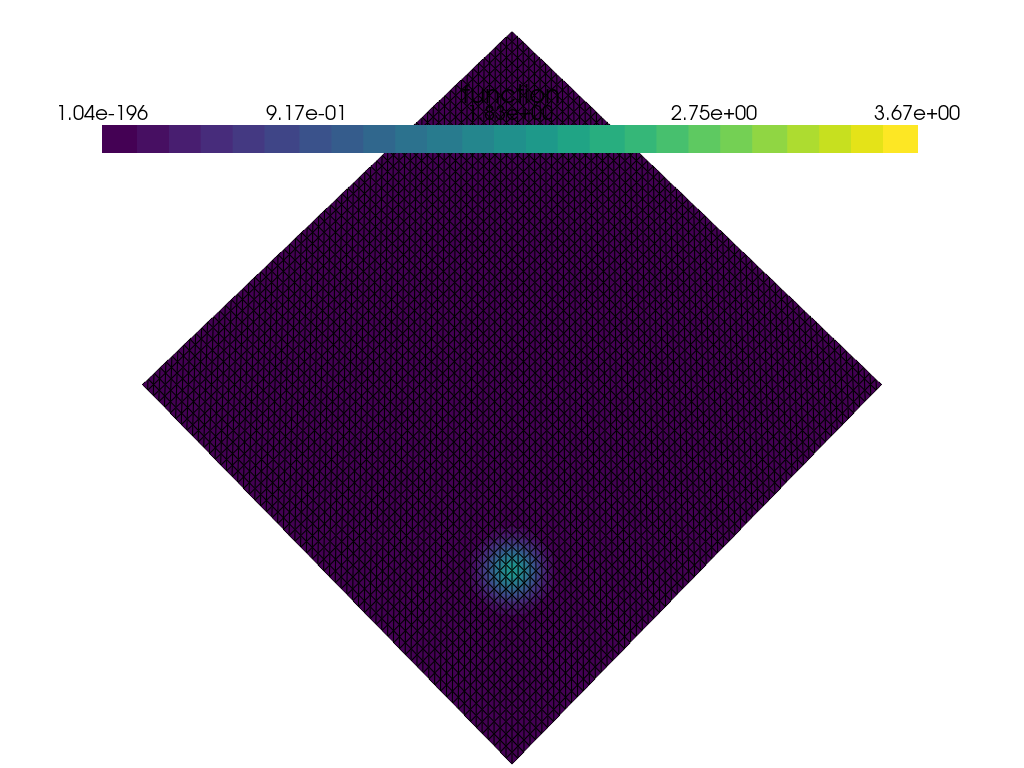

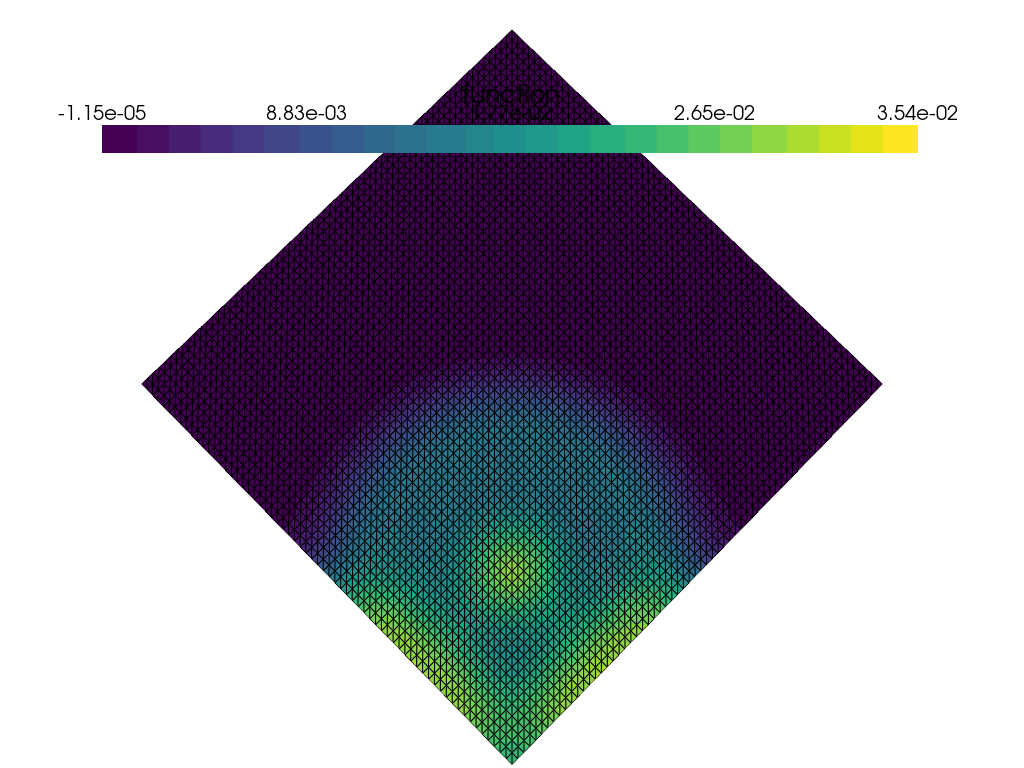

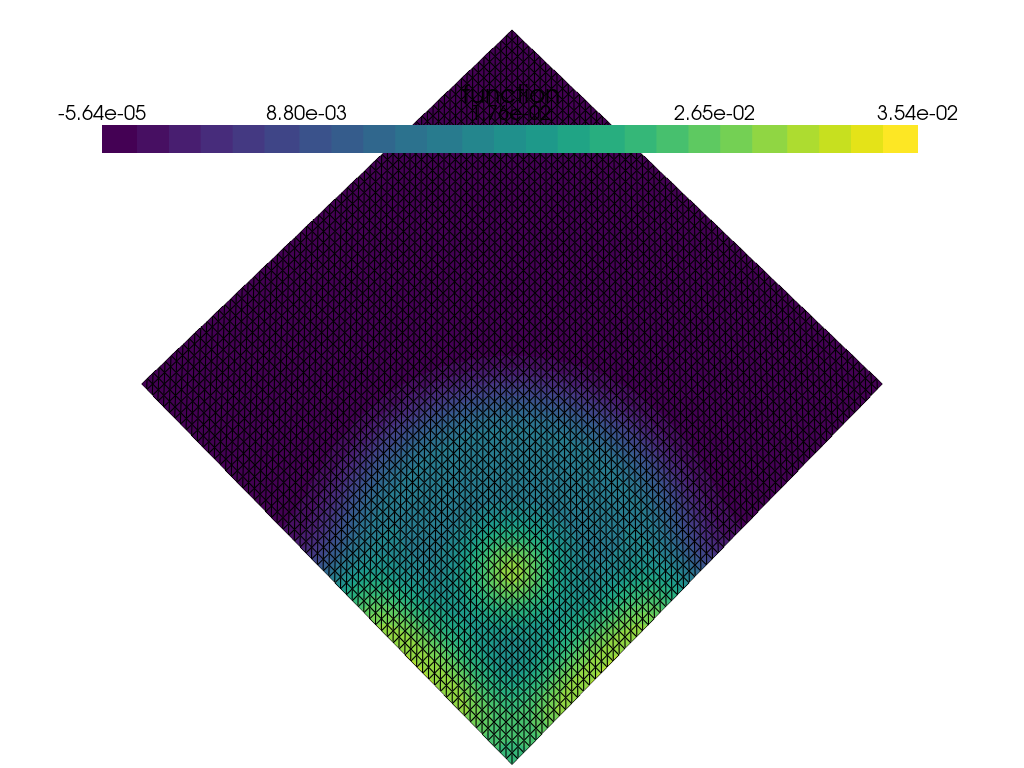

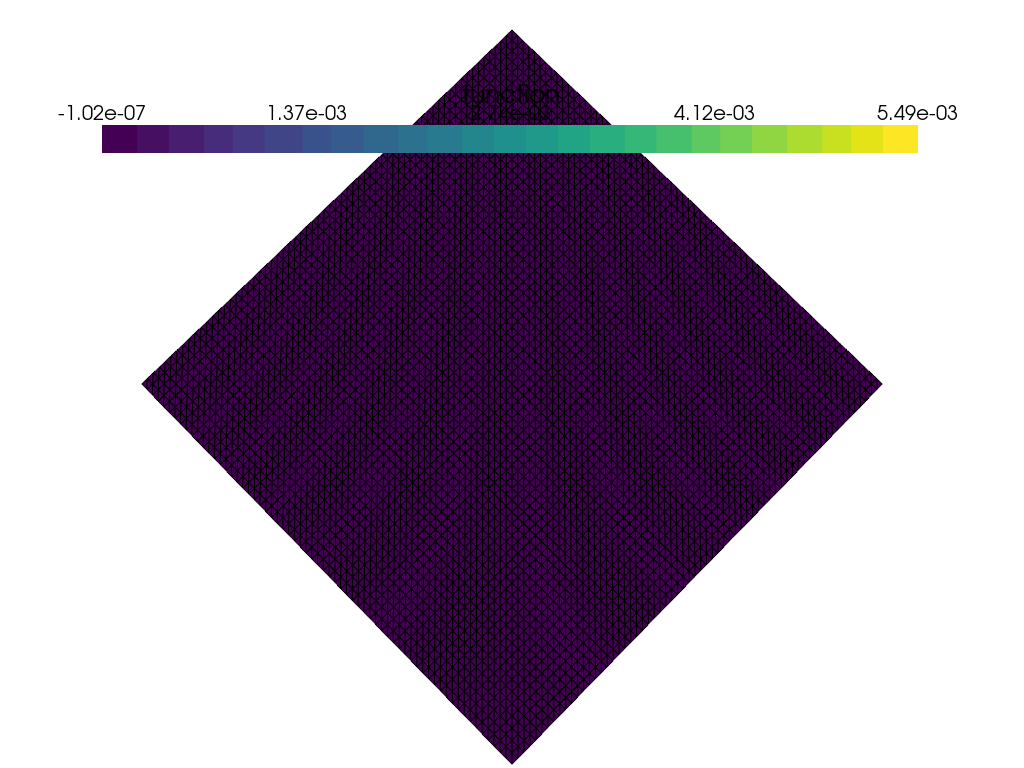

In [3]:
s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))
s2 = lambda t : 0#0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))
'''
active_set = []
new_point = ExtremalPoint(np.array([1, 0]), 0.25, type=0, params=params, idx=int(0.25/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([-1, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([1, 0]), 0.75, type=0, params=params, idx=int(0.75/params.dt))
active_set.append(new_point)

weights = np.ones(len(active_set)) * params.alpha
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
s1 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[0]
s2 = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)[1]
'''
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)

control = buildControlFunction([g1, g2], [s1, s2], params)
K_u = solveStateEquation(control, params)
grid_size = K_u[0].x.array.shape

# Creating the measured state
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
params.yd = yd
timeDependentVariableToGif(control, 'output/control.gif')
timeDependentVariableToGif(K_u, 'output/original_state.gif')
timeDependentVariableToGif(yd, 'output/observation.gif')
timeDependentVariableToGif(solveAdjointEquation(yd, params), 'output/adjoint.gif')

## Iterative method

Newton solution:  [ 0.00000000e+00  4.05480370e-01  4.57628754e-03  3.73436528e+03
 -1.64657579e+00 -3.36612705e+02  8.61753951e-01]
weights: [0.         0.40548037 0.00457629]


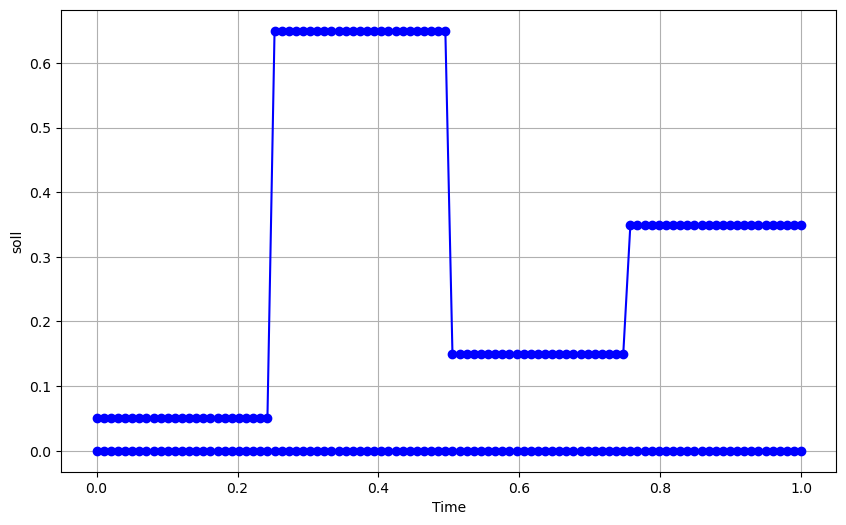

Iteration  0
Objective:  438.2550127820745


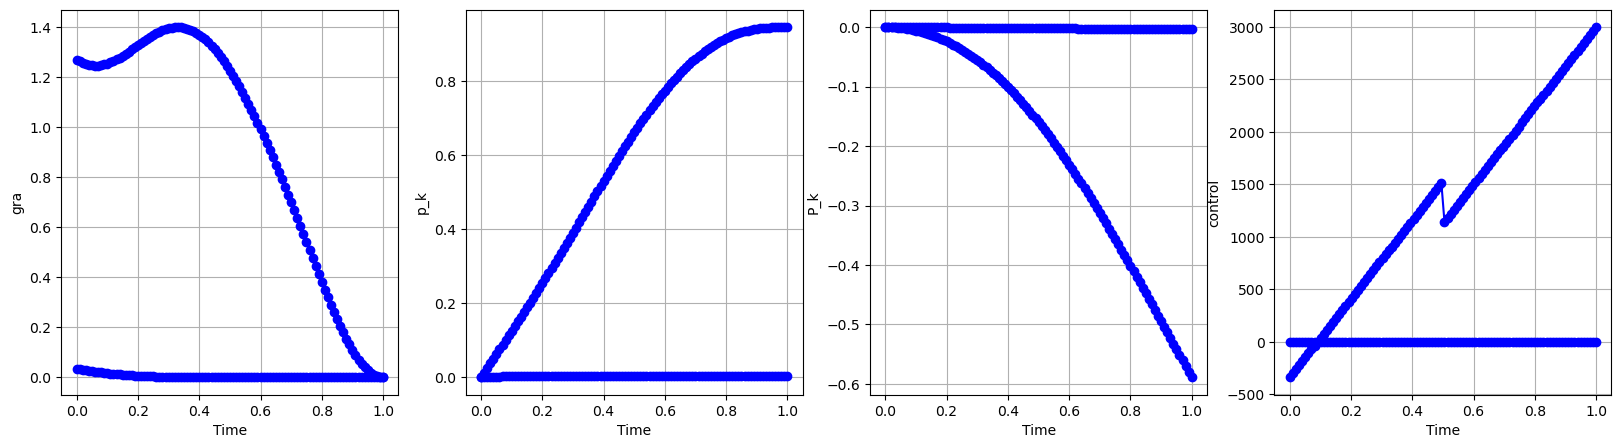

Added point: [0.99999077 0.00429766] 0.99 type 0
Newton solution:  [ 5.34290077e+01  8.16876720e+01  8.14219142e+04 -1.72245546e+05
 -3.25213935e+02 -1.54232838e+04  1.66027157e+02]
Iteration  1
Objective:  4378057.426511289


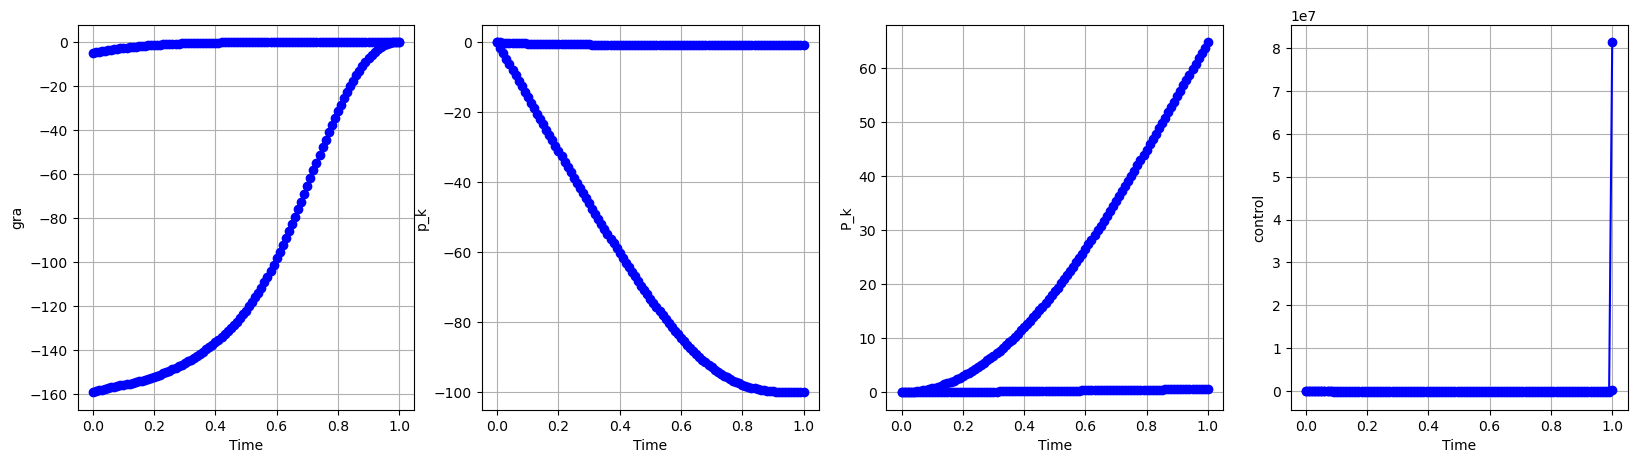

Added point: [-0.99997652 -0.00685266] 0.98 type 0
Newton solution:  [ 5.34287994e+01  8.16873594e+01  8.14215959e+04  0.00000000e+00
 -1.72246335e+05 -3.25213040e+02 -1.54232234e+04  1.66026596e+02]
Iteration  2
Objective:  4378074.153135463


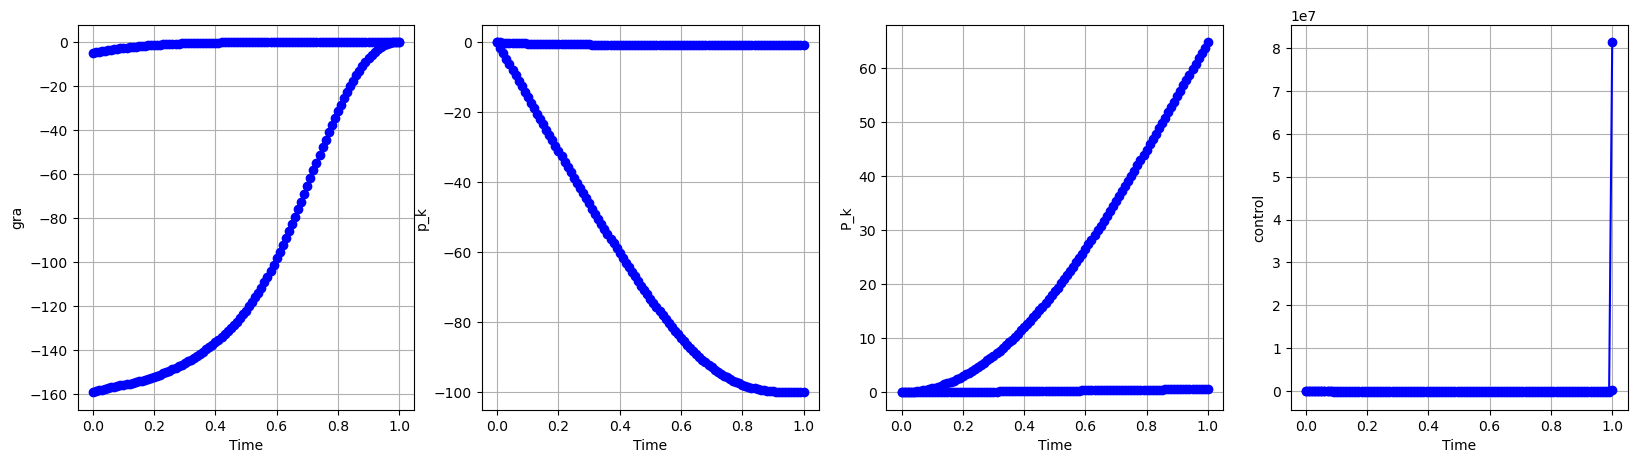

Added point: [-0.99997652 -0.00685266] 0.98 type 0
Newton solution:  [ 3.78469823e-07  8.11071462e+01  0.00000000e+00  0.00000000e+00
  3.59439476e+04  6.69360207e+02  1.74822514e+04 -2.75811665e+02]
Iteration  3
Objective:  696362.5913293901


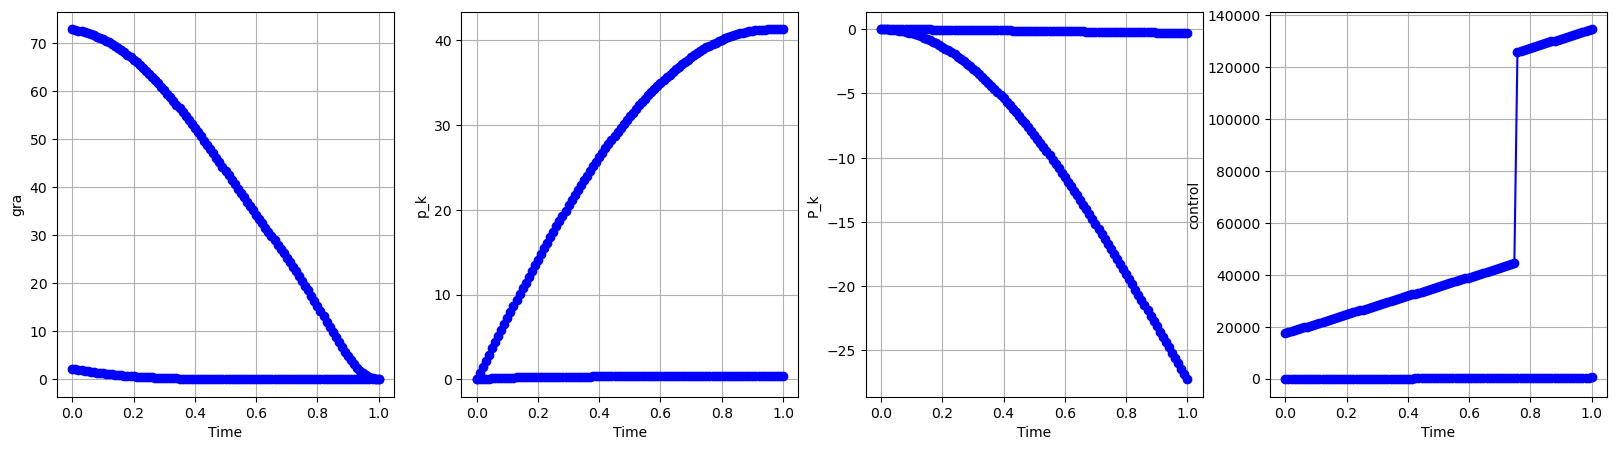

Added point: [0.99996692 0.00813327] 0.99 type 0
Newton solution:  [ 2.84621033e+01  1.00121765e+04  6.36341938e+03 -5.07470406e+02
 -3.04912065e+04 -1.87408507e+03]
Iteration  4
Objective:  545847.9082146655


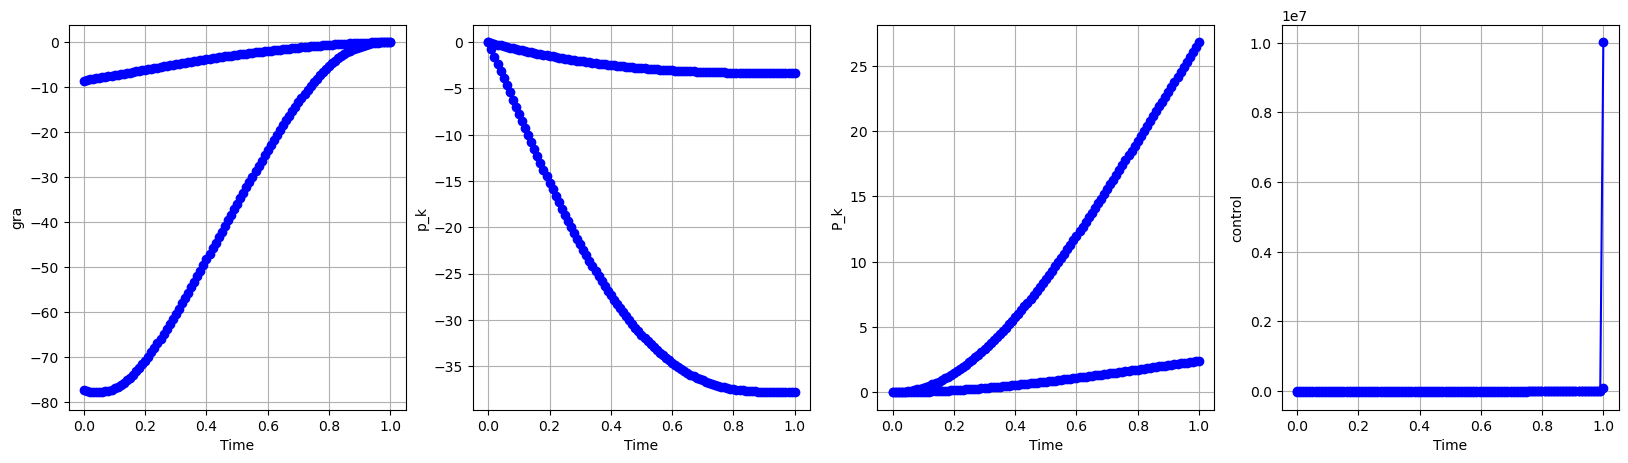

Added point: [-0.99613505 -0.08783491] 0.98 type 0
Newton solution:  [ 1.00597483e+02  3.75634607e+04  2.14860274e+05  1.37214189e+04
 -1.46717693e+03  8.53991193e+05 -3.57211611e+03]
Iteration  5
Objective:  501046743.14293516


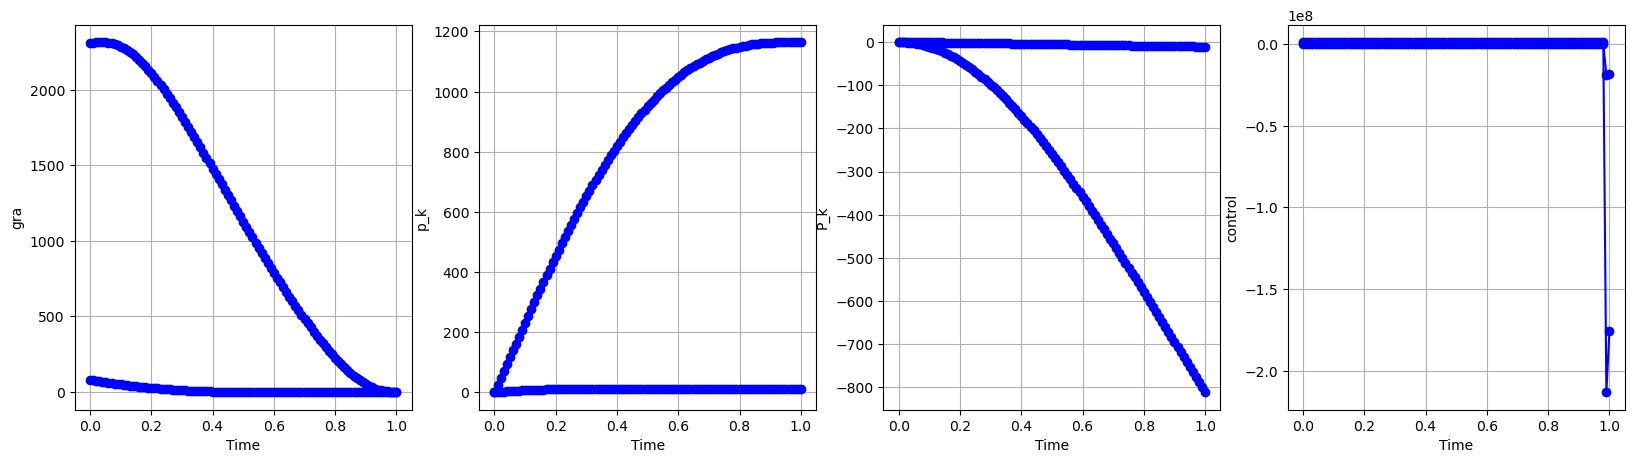

Added point: [0.99995802 0.00916261] 0.97 type 0
Newton solution:  [ 2.63806455e+01  9.24695848e+03  0.00000000e+00  1.37582158e+03
  5.90135607e+03 -4.71963416e+02 -4.49494128e+04 -1.73809637e+03]
Iteration  6
Objective:  1243394.4995052486


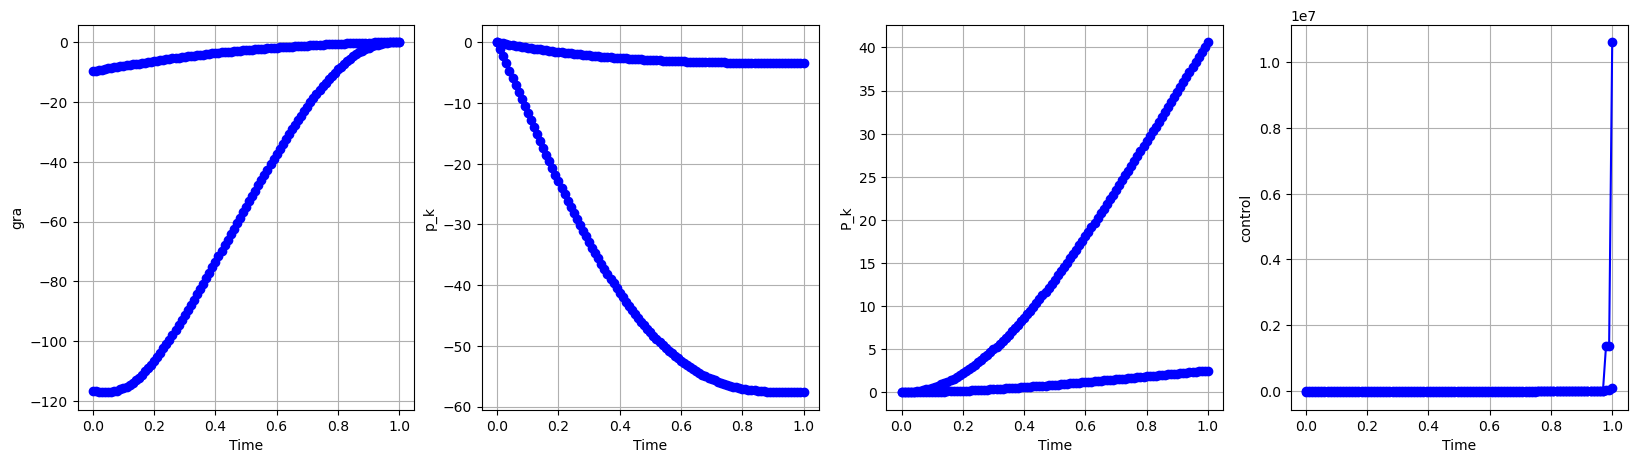

Added point: [-0.99824431 -0.05923091] 0.98 type 0
Newton solution:  [ 2.70738230e+01  1.00987963e+04  1.59361228e+03  0.00000000e+00
  1.41238152e+03 -4.80462615e+02 -3.93297572e+04  1.18905754e+01]
Iteration  7
Objective:  1003364.7261634415


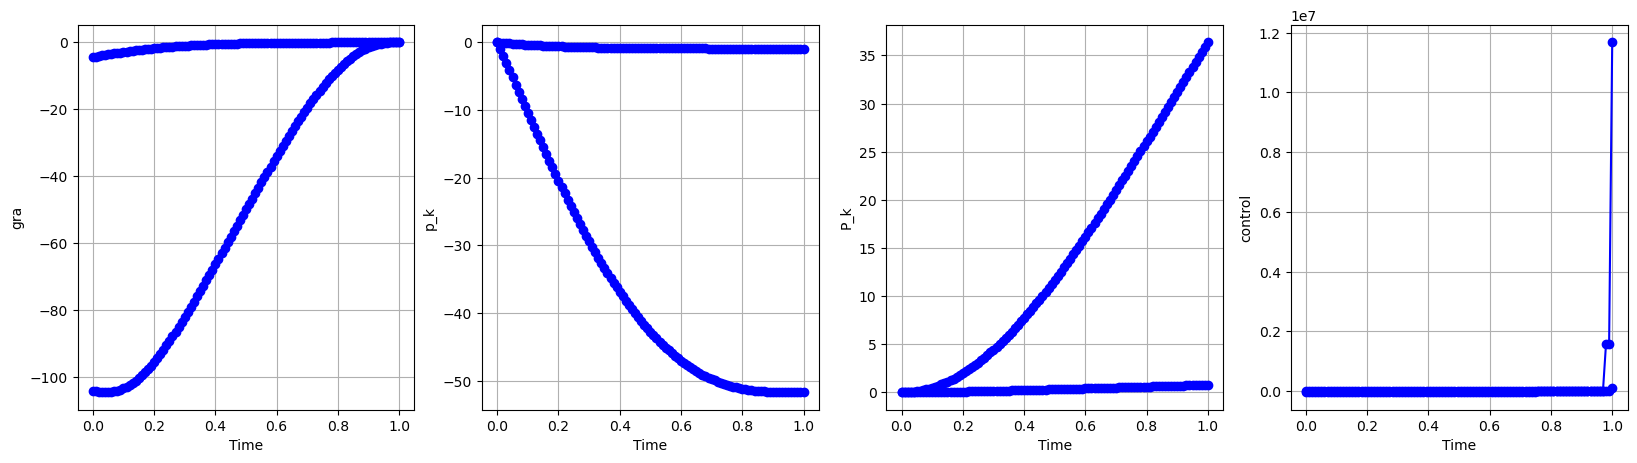

Added point: [-0.99983363 -0.01824056] 0.98 type 0
Newton solution:  [ 2.67514586e+01  9.97003194e+03  3.65200223e+03  7.71062084e+03
  2.04553152e+03 -4.69857106e+02 -2.66685453e+04  2.07059427e+01]
Iteration  8
Objective:  460228.8036636082


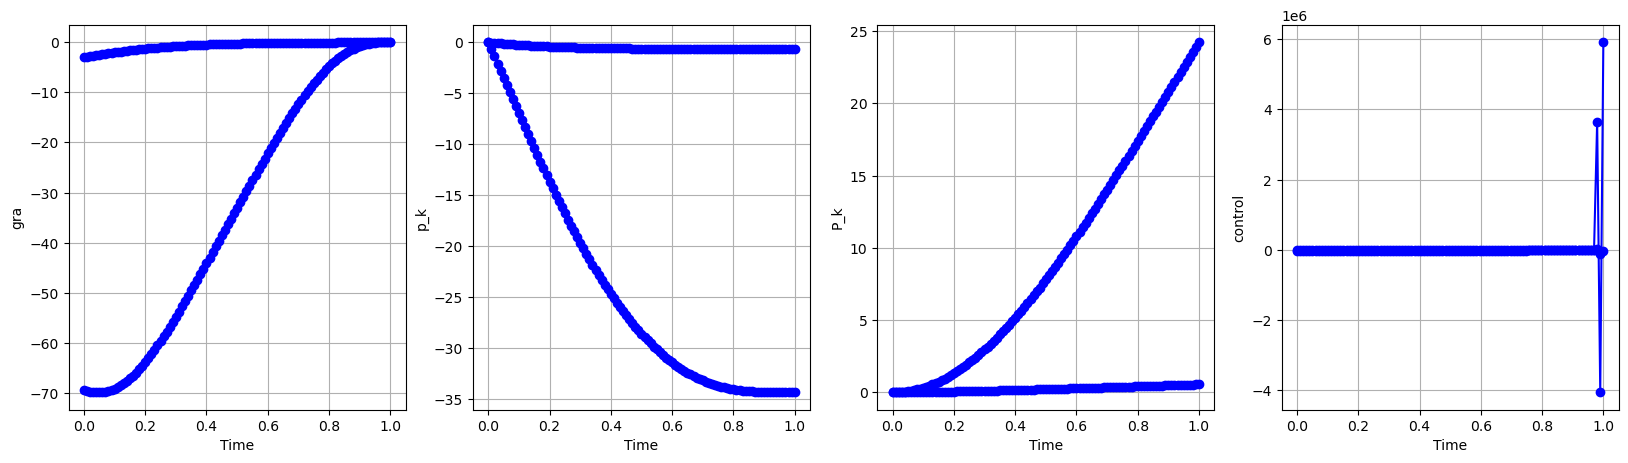

Added point: [-0.99980363 -0.01981654] 0.96 type 0
Newton solution:  [ 2.67514238e+01  9.97001186e+03  3.65173091e+03  7.71078003e+03
  0.00000000e+00  2.04660991e+03 -4.69856601e+02 -2.66651012e+04
  2.07060796e+01]
Iteration  9
Objective:  460099.9682801623


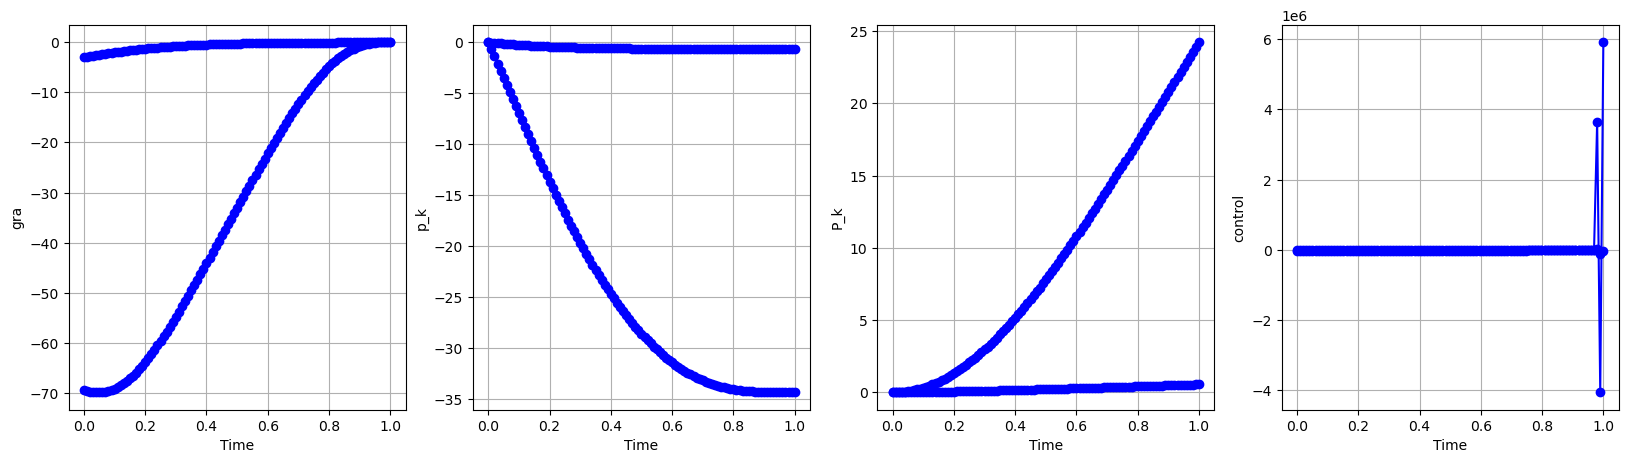

Added point: [-0.99980362 -0.01981742] 0.96 type 0
Newton solution:  [ 2.68000371e+01  1.00112773e+04  5.26857762e+03  7.27055624e+03
  0.00000000e+00  8.15240041e+02 -4.69977076e+02 -3.64992390e+04
  2.09110454e+01]
Procedure stopped after  10  iterations


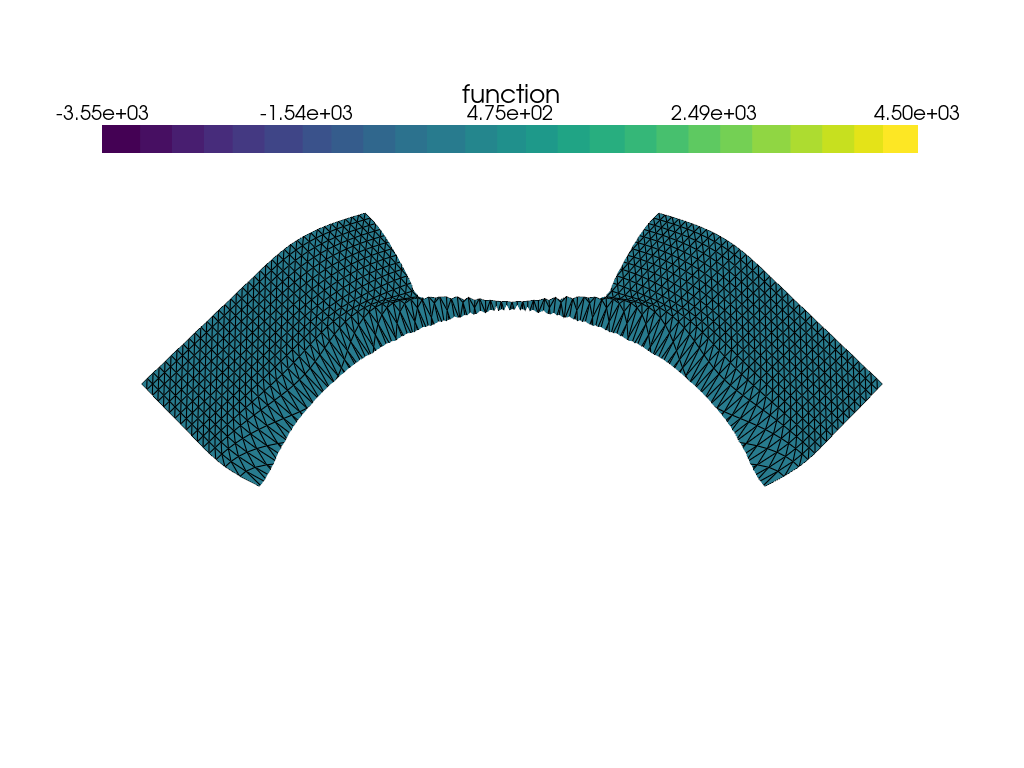

In [4]:
active_set = []

new_point = ExtremalPoint(np.array([1, 0]), 0.25, type=0, params=params, idx=int(0.25/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([-1, 0]), 0.5, type=0, params=params, idx=int(0.5/params.dt))
active_set.append(new_point)
new_point = ExtremalPoint(np.array([1, 0]), 0.75, type=0, params=params, idx=int(0.75/params.dt))
active_set.append(new_point)
#new_point = ExtremalPoint(np.array([1.0, 0]), 0.2, type=1, params=params, idx=int(0.2/params.dt))
#active_set.append(new_point)

hesseMatrix = HesseMatrix(active_set, params)
weights = np.zeros(len(active_set))
slope = np.zeros((params.d,))
y_shift = np.zeros((params.d,))
params.newton_c = 3
timepoints = np.linspace(0, params.T, int(params.T / params.dt))
#print('Hesse: ', hesseMatrix.matrix)
#print('cond: ', np.linalg.cond(hesseMatrix.matrix))
weights, slope, y_shift = computeSemiNewtonStep(weights, slope, y_shift, active_set, hesseMatrix, params)
print('weights:', weights)
active_set, weights = pruneActiveSet(active_set, weights)
u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
#plot_function(u_k, params.T, params.dt)
array = np.ndarray((len(timepoints), 2))
array[:, 0] = np.array([s1(t) for t in timepoints])
array[:, 1] = np.array([s2(t) for t in timepoints])
plot_array(array, params.T, label='soll')
max_iteration = 10
for k in range(max_iteration):
	print('Iteration ', k)
	x = np.concatenate((weights, slope, y_shift))
	print('Objective: ', computeObjective(x, active_set, hesseMatrix.standard_states, params))

	u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)

	# Calculate dual variables
	gradIn_u_k = calculateDiscreteGradient(u_k, yd, params)
	p = integrateVectorFunction(gradIn_u_k, params)
	P = -integrateVectorFunction(p, params)
	fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
	plot_array(gradIn_u_k, params.T, label='gra', ax=ax1)
	plot_array(p, params.T, label='p_k', ax=ax2)
	plot_array(P, params.T, label='P_k', ax=ax3)
	
	plot_array(np.array([u_k(t) for t in timepoints]), params.T, label='control', ax=ax4)
	mpl.pyplot.show()
	idx_xS = getIdxMax(p, active_set, type=0)
	idx_xK = getIdxMax(P, active_set, type=1)

	p_max = np.linalg.norm(p[idx_xS])
	P_max = np.linalg.norm(P[idx_xK])
	if (max(p_max / params.alpha, P_max / params.beta) <= 1):
	    break
	# Add new extremal point to the active set
	if (p_max / params.alpha > P_max / params.beta):
		new_point = ExtremalPoint(p[idx_xS] / p_max, idx_xS * params.dt, type=0, params=params, idx=idx_xS)
	else:
		new_point = ExtremalPoint(P[idx_xK] / P_max, idx_xK * params.dt, type=1, params=params, idx=idx_xK)
	active_set.append(new_point)
	hesseMatrix.update(active_set)
	print('Added point:', new_point.sigma, new_point.x_0, 'type', new_point.type)
	#print(hesseMatrix.matrix)
	weights_temp = np.ones(len(active_set))
	weights_temp[:-1] = weights
	weights, slope, y_shift = computeSemiNewtonStep(weights_temp, slope, y_shift, active_set, hesseMatrix, params)
	# Prune extremal points which are not used
	active_set, weights = pruneActiveSet(active_set, weights)
	
	
print('Procedure stopped after ', k + 1, ' iterations')
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
s1 = lambda t: u_k(t)[0]
s2 = lambda t: u_k(t)[1]
control = buildControlFunction([g1, g2], [s1, s2], params)
timeDependentVariableToGif(solveStateEquation(control, params), 'output/reconstruction.gif')

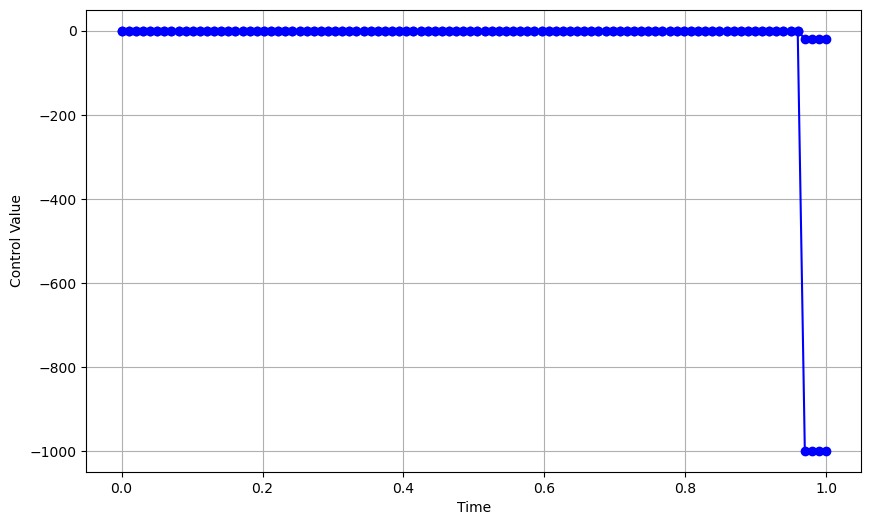

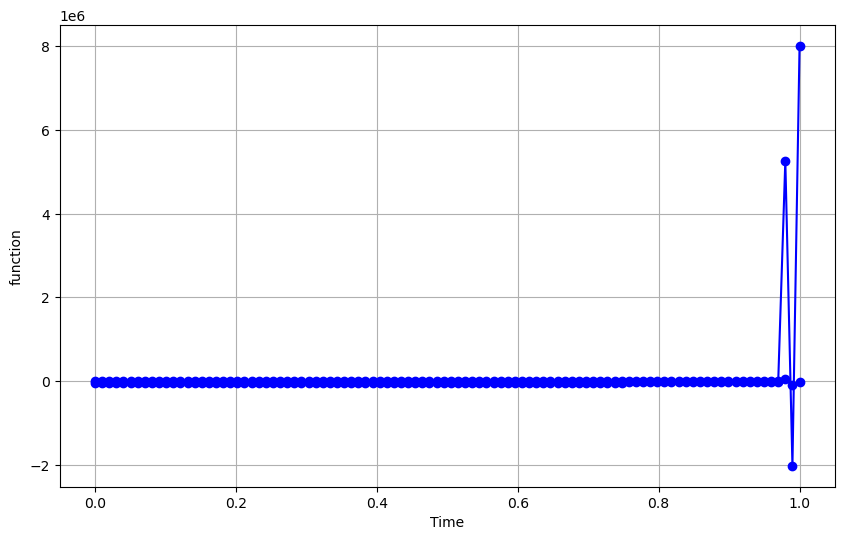

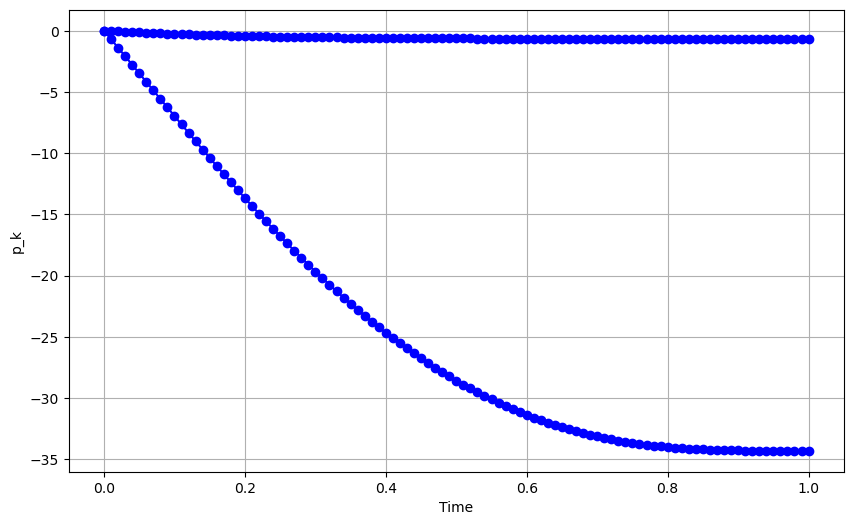

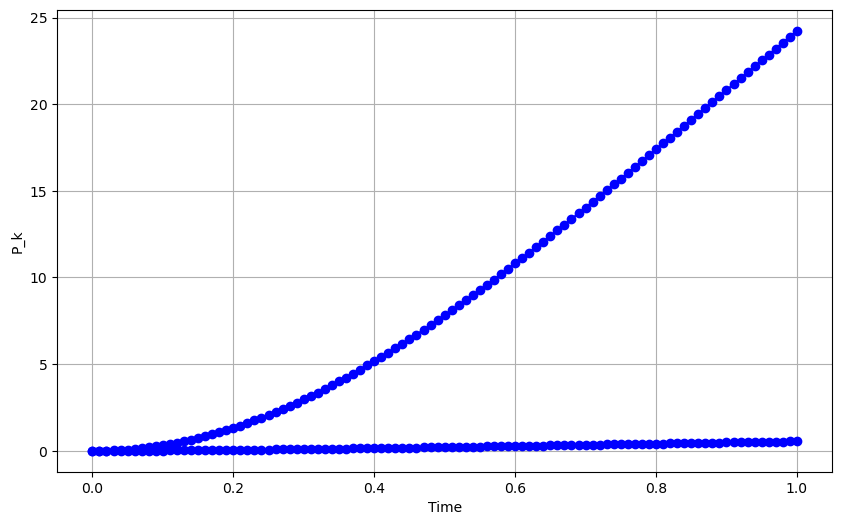

In [5]:
timepoints = np.linspace(0, params.T, int(params.T / params.dt))
array = np.array([new_point.value(t) for t in timepoints])
mpl.pyplot.figure(figsize=(10, 6))
mpl.pyplot.plot(timepoints, array, marker='o', linestyle='-', color='b')
mpl.pyplot.xlabel('Time')
mpl.pyplot.ylabel('Control Value')
mpl.pyplot.grid(True)
mpl.pyplot.show()
plot_function(u_k, params.T, params.dt)
plot_array(p, params.T, label='p_k')
plot_array(P, params.T, label='P_k')



#for idx, extremalPoint in enumerate(active_set):
#    print(idx, 'sigma: ', extremalPoint.sigma, 'x0: ', extremalPoint.x_0, 'weight: ', weights[idx], 'type', extremalPoint.type)

In [6]:
'''s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))
s2 = lambda t : 0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
K_u, __ = solveStateEquation([g1, g2], [s1, s2], params)
phi = [fem.Function(params.V) for _ in K_u]
for idx in range(len(phi)):
	phi[idx].x.array[:] = K_u[idx].x.array - 0* yd[idx].x.array
adjointState = solveAdjointEquation(phi, params)
adjointValues = np.ndarray((len(adjointState), params.d), dtype=np.float64)
discretControl = np.ndarray((len(adjointState), params.d), dtype=np.float64)
for idx, func in enumerate(adjointState):
	adjointValues[idx] = getValueOfFunction(params.V, func, [params.x1, params.x2])[:, 0]
	discretControl[idx, 0] = s1(idx * params.dt)
	discretControl[idx, 1] = s2(idx * params.dt)
euklideanProducts = np.einsum('ij,ij->i', adjointValues, discretControl)
#print(euklideanProducts)

alternative = np.ndarray((len(adjointState), ), dtype=np.float64)
for idx, func in enumerate(K_u):
    energy_form = fem.form(inner(func, func) * dx)
    energy_local = fem.assemble_scalar(energy_form)
    alternative[idx] = params.V.mesh.comm.allreduce(energy_local, op=MPI.SUM)

relative_error = np.ndarray((len(adjointState), ), dtype=np.float64)
for idx in range(len(adjointState)):
    relative_error[idx] = (alternative[idx] - euklideanProducts[idx]) / min(abs(alternative[idx]), abs(euklideanProducts[idx]))
#print(5 * alternative - euklideanProducts)
print(relative_error.mean())
print(np.linalg.sum(alternative), np.linalg.sum(euklideanProducts))'''

"s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35))\ns2 = lambda t : 0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275))\n\ng1 = getSourceTerm(params.x1, params)\ng2 = getSourceTerm(params.x2, params)\nK_u, __ = solveStateEquation([g1, g2], [s1, s2], params)\nphi = [fem.Function(params.V) for _ in K_u]\nfor idx in range(len(phi)):\n\tphi[idx].x.array[:] = K_u[idx].x.array - 0* yd[idx].x.array\nadjointState = solveAdjointEquation(phi, params)\nadjointValues = np.ndarray((len(adjointState), params.d), dtype=np.float64)\ndiscretControl = np.ndarray((len(adjointState), params.d), dtype=np.float64)\nfor idx, func in enumerate(adjointState):\n\tadjointValues[idx] = getValueOfFunction(params.V, func, [params.x1, params.x2])[:, 0]\n\tdiscretControl[idx, 0] = s1(idx * params.dt)\n\tdiscretControl[idx, 1] = s2(idx * params.dt)\neuklideanProducts = np.einsum('ij,ij->i', adjointValues, discretControl)\n#print(euklideanProducts